In [27]:
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import prune

import numpy as np
import matplotlib.pyplot as plt
import copy

plt.rcParams['font.family'] = 'Bookman Old Style'


class dataset:
    def __init__(self, x, y, num_training_points=5000, num_memory_levels =3):
        self.num_training_points = num_training_points
        self.num_memory_levels = num_memory_levels # If there are 0 memory taps, this is 1
        self.x = x
        self.y = y

        self.model_training_input, self.model_training_output, self.training_phase, self.model_valid_input, self.model_valid_output, self.valid_phase = self.prepare_data()
        self.model_training_xfc = self.get_model_training_xfc()
        self.model_training_expected_output = self.get_model_training_expected_output()
        self.model_valid_xfc = self.get_valid_xfc()
        self.model_valid_expected_output = self.get_model_valid_expected_output()

        


        
    def phase_vector(self, x):    
        """Takes a vector x and returns a vector of phases of each element"""
        Ax = np.abs(x)
        return np.conj(x)/Ax

    def model_expected_output(self, y, phase):
        """Take in data, phase normalised it, and trim. Return as IQ seperately"""
        y_denorm = y*phase
        y_denorm_trim = y_denorm[self.num_memory_levels:]
        return np.array([np.real(y_denorm_trim), np.imag(y_denorm_trim)]).T

    def build_xfc(self, x, num_memory_levels):
        """
        Replicates the MATLAB build_xfc() function.
        """
        num_points = len(x)
        phase = self.phase_vector(x)
        I = np.real(x)
        Q = np.imag(x)

        # Phase-normalized data
        phase_norm_data = np.zeros((num_points, num_memory_levels), dtype=complex)
        for n in range(num_memory_levels, num_points):
            for m in range(num_memory_levels):
                phase_norm_data[n, m] = x[n - m - 1] * phase[n]

        # Ax magnitude feature
        Ax = np.sqrt(I**2 + Q**2)

        # Build A feature matrix (Ax memory taps)
        A_feats = np.zeros((num_points, num_memory_levels))
        for n in range(num_memory_levels, num_points):
            for m in range(num_memory_levels):
                A_feats[n, m] = Ax[n - m]

        # Trim first num_memory_levels samples (as in MATLAB)
        phase_norm_data = phase_norm_data[num_memory_levels:, :]
        A_feats = A_feats[num_memory_levels:, :]
        A3_feats = A_feats ** 3

        # Combine real and imaginary phase-normalized parts with A-features
        xfc = np.hstack([
            np.real(phase_norm_data),
            np.imag(phase_norm_data),
            A_feats,
            A3_feats
        ]).astype(np.float32)

        return xfc

    def build_x_matrix(self, x, num_mem_levels, num_nl_orders):
        """Build Matrix X for find Volterra Model"""
        num_points = len(x)
        X = np.zeros((num_points, num_mem_levels * num_nl_orders), dtype=np.complex128)
        
        for n in range(num_mem_levels - 1, num_points):
            col = 0
            for i in range(num_mem_levels):
                xi = x[n - i]
                for j in range(num_nl_orders):
                    X[n, col] = (abs(xi) ** ((j) * 2)) * xi
                    col += 1

        return X

    def build_y(self, u, A, num_mem_levels, num_nl_orders):
        """Builds y, the output of the volterra Model. Trims Output"""
        num_points = len(u)
        y = np.zeros((num_points, 1), dtype=np.complex128)
        for n in range(num_mem_levels - 1, num_points):
            col = 0 
            for i in range(num_mem_levels):
                ui = u[n-i]
                for j in range(num_nl_orders):
                    y[n]= y[n] + A[col]*(abs(ui)**(j*2)*ui)
                    col += 1
        y = y[self.num_memory_levels:]
        return y
            

    def volterra(self,num_nl_orders, num_memory_levels=3):
        """Build component matrix A"""
        X = self.build_x_matrix(self.model_training_output, num_memory_levels, num_nl_orders)
        
        X_trim = X[num_memory_levels:, :]
        y_trim = self.model_training_input[num_memory_levels:]
        return np.linalg.pinv(X_trim.conj().T @ X_trim) @ (X_trim.conj().T @ y_trim);

    def training_data(self):
        """Assign some data for just training"""
        idx_training = range(0, self.num_training_points -1) # training indices

        model_training_input = self.y[idx_training]
        model_training_output = self.x[idx_training]
        return model_training_input, model_training_output
    

    def get_validation_data(self):
        """Assign some data for just validation"""
        num_validation_points = self.num_training_points 
        validation_end_index = self.num_training_points + num_validation_points
        idx_validation = range(self.num_training_points, validation_end_index -1) # validation indices
        model_valid_input = self.y[idx_validation]
        model_valid_output = self.x[idx_validation]
        return model_valid_input, model_valid_output
    
    def get_leftover_test_data(self):
        """Get data left over that wasnt used for validation or training"""
        num_test_start = self.num_training_points * 2
        x_test = self.x[num_test_start:]
        y_test = self.y[num_test_start:]
        return x_test, y_test

    def prepare_data(self):
        """Prepare training and validation data sets"""
        # Training Data
        model_training_input, model_training_output = self.training_data()
        training_phase = self.phase_vector(model_training_input)

        # Validation Data
        model_valid_input, model_valid_output = self.get_validation_data()
        valid_phase = self.phase_vector(model_valid_input)
        return (model_training_input, model_training_output, training_phase,
                model_valid_input, model_valid_output, valid_phase)

    def get_model_training_xfc(self):
        """Build xfc from model training input"""
        return self.build_xfc(self.model_training_input, self.num_memory_levels)
    
    def get_model_training_expected_output(self):
        """Find what the model should output for training data"""
        return self.model_expected_output(self.model_training_output, self.training_phase)
    
    def get_valid_xfc(self):
        """Build xfc from model validation input"""
        return self.build_xfc(self.model_valid_input, self.num_memory_levels)
    
    def get_test_xfc(self):
        return self.build_xfc(self.test_input, self.num_memory_levels)
    
    def get_model_valid_expected_output(self):
        """Find what the model should output for validation data"""
        return self.model_expected_output(self.model_valid_output, self.valid_phase)
    
    def get_test_data(self, num_points):
        """Get test data after validation"""
        num_validation_points = self.num_training_points 
        validation_end_index = self.num_training_points + num_validation_points
        x_data = self.x[validation_end_index:validation_end_index+num_points]
        y_data = self.y[validation_end_index:validation_end_index+num_points]
        return x_data, y_data


# Load data
data = scipy.io.loadmat("PA_IO.mat")
x = data["x"].squeeze()
y = data["y"].squeeze()

# Create dataset object
data_obj = dataset(x, y)

In [28]:
# Get Volterra Model of PA
num_memory_levels = 3
num_nl_orders = 5
A = data_obj.volterra(num_nl_orders, num_memory_levels)
print(A)

[ 1.54996424+0.231149j   -0.42706522-0.31633449j -1.50564817+1.90788486j
  2.98722013-3.08261378j -1.59404636+1.66147922j -0.22545683-0.44929453j
  0.03761166-0.04908903j  0.03710063+0.33581504j -0.04496924-0.76784164j
  0.01303703+0.53153523j  0.12826453+0.26006374j -0.03763837-0.0102274j
  0.04533442+0.10082778j -0.04063175-0.27397055j  0.0058124 +0.22612464j]


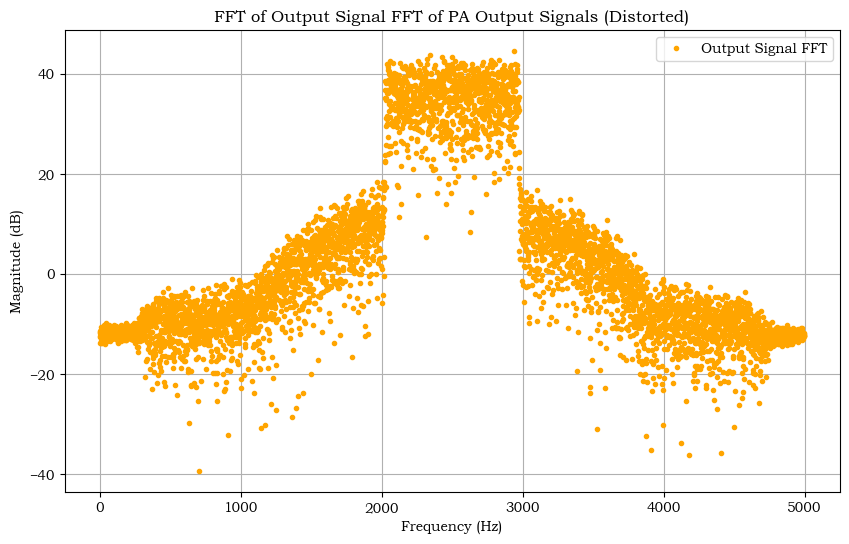

In [29]:
# Plot the FFT of the data
def plot_fft_data(y, y1=None, title_suffix=""):
    """Plot the FFT of the output data, optionally with a second signal"""
    Y = np.fft.fft(y, n=len(y))
    Y_flip = np.fft.fftshift(Y)
    # Convert to dB
    Y_dB = 20 * np.log10(np.abs(Y_flip))
    
    if y1 is not None:
        Y1 = np.fft.fft(y1, n=len(y1))
        Y1_flip = np.fft.fftshift(Y1)
        # Convert to dB
        Y1_dB = 20 * np.log10(np.abs(Y1_flip))
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        ax1.plot(Y_dB, '.', color='orange', markersize=6)
        ax1.set_title('First Signal FFT')
        ax1.set_xlabel('Frequency (Hz)')
        ax1.set_ylabel('Magnitude (dB)')
        ax1.grid()
        
        ax2.plot(Y1_dB, '.', color='blue', markersize=6)
        ax2.set_title('Second Signal FFT')
        ax2.set_xlabel('Frequency (Hz)')
        ax2.set_ylabel('Magnitude (dB)')
        ax2.grid()
        
        plt.suptitle(f'FFT of Output Signals {title_suffix}')
        plt.tight_layout()
    else:
        plt.figure(figsize=(10, 6))
        plt.plot(Y_dB, '.', label='Output Signal FFT', color='orange', markersize=6)
        plt.title(f'FFT of Output Signal {title_suffix}')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude (dB)')
        plt.grid()
        plt.legend()
    
    plt.show()

valid_input = data_obj.model_valid_input
training_input = data_obj.model_training_input #Note that the training_input data is actuall the output of the PA
#Plot the PA output (distorted signal with intermodulation products)
plot_fft_data(training_input, title_suffix="FFT of PA Output Signals (Distorted)")



In [30]:
# Train NN on backprop PA for inv model

class PNTDNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(PNTDNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 2)

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))
    


class PNTDNN_3_layers(nn.Module):    
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(PNTDNN_3_layers, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 2)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

class NN:
    def __init__(self, dataset_obj, model_type):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.input_size = dataset_obj.model_training_xfc.shape[1]
        self.pntdnn = self.get_model(model_type)
        self.dataset_obj = dataset_obj
        self.train_loader = self.build_dataloaders(dataset_obj.model_training_xfc, dataset_obj.model_training_expected_output)
        self.valid_loader = self.build_dataloaders(dataset_obj.model_valid_xfc, dataset_obj.model_valid_expected_output)

    def get_model(self, model_type):
        if model_type == "one_layer_12_neurons":
            hidden_size = 12
            return PNTDNN(self.input_size, hidden_size)
        else:
            raise ValueError("Unsupported model type")
        
    def build_dataloaders(self, x , y):
        X = torch.tensor(x, dtype=torch.float32)
        Y = torch.tensor(y, dtype=torch.float32)
        dataset = TensorDataset(X, Y)
        loader = DataLoader(dataset, batch_size=256, shuffle=True)
        return loader

    
    def get_best_model(self, num_epochs=400, learning_rate=1e-3):
        """Train model and return the best model based on validation loss"""
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.pntdnn.parameters(), lr=learning_rate)
        
        train_losses = []
        valid_losses = []
        best_valid_loss = float('inf')
        best_model_state = None
        best_epoch = 0
        
        for epoch in range(num_epochs):
            self.pntdnn.train()
            running_train_loss = 0
            running_valid_loss = 0
            
            for xb, yb in self.train_loader:
                optimizer.zero_grad()
                preds = self.pntdnn(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()
                running_train_loss += loss.item() * xb.size(0)
                
            train_loss = running_train_loss
            
            self.pntdnn.eval()
            with torch.no_grad():
                for xb, yb in self.valid_loader:
                    preds = self.pntdnn(xb)
                    loss = criterion(preds, yb)
                    running_valid_loss += loss.item() * xb.size(0)
                
            valid_loss = running_valid_loss
            
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            
            # Save best model
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                best_model_state = copy.deepcopy(self.pntdnn.state_dict())
                best_epoch = epoch + 1
            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1:3d}/{num_epochs}  Loss={train_loss:.4e}  Valid Loss={valid_loss:.4e}")
        
        # Load best model
        self.pntdnn.load_state_dict(best_model_state)
        print(f"\nBest model from epoch {best_epoch} with validation loss: {best_valid_loss:.4e}")
        
        return train_losses, valid_losses, best_epoch

    def prune_model(self, parameters_to_prune_list, prune_amount=0.2):
        """Apply pruning to the model in-place"""
        parameters_to_prune = []

        if "fc1" in parameters_to_prune_list:
            parameters_to_prune.append((self.pntdnn.fc1, 'weight'))
        if "fc2" in parameters_to_prune_list:
            parameters_to_prune.append((self.pntdnn.fc2, 'weight'))
        if "fc3" in parameters_to_prune_list:
            parameters_to_prune.append((self.pntdnn.fc3, 'weight'))
        
        prune.global_unstructured(
            parameters_to_prune,
            pruning_method=prune.L1Unstructured,
            amount=prune_amount,
        )
    
    def get_pruning_percentage(self):
        """Calculate the current percentage of pruned weights"""
        total_params = 0
        pruned_params = 0
        for name, module in self.pntdnn.named_modules():
            if isinstance(module, nn.Linear):
                if hasattr(module, 'weight_mask'):
                    mask = module.weight_mask
                    total_params += mask.numel()
                    pruned_params += (mask == 0).sum().item()
                else:
                    total_params += module.weight.numel()
        
        return (pruned_params / total_params * 100) if total_params > 0 else 0
    
    def calculate_nmse(self):
        """Return NMSE in dB"""
        self.pntdnn.eval()
        x = self.dataset_obj.model_training_xfc
        y = self.dataset_obj.model_training_expected_output
        with torch.no_grad():
            inputs = torch.tensor(x, dtype=torch.float32)
            targets = torch.tensor(y, dtype=torch.float32)
            outputs = self.pntdnn(inputs)
            mse_loss = nn.MSELoss()(outputs, targets).item()
            signal_power = torch.mean(targets ** 2).item()
            nmse = mse_loss / signal_power
            nmse = 10 * np.log10(nmse)
        return nmse
    
    def evaluate_nn_output(self, x):
        """Evaluate model output for given input x."""
        self.pntdnn.eval()
        with torch.no_grad():
            inputs = torch.tensor(x, dtype=torch.float32)
            outputs = self.pntdnn(inputs)
        return outputs.numpy()
    
    def evaluate_phase_denormalised_output(self, x, phase):
        """Evaluate model output for given input x with phase denormalization."""
        nn_outputs = self.evaluate_nn_output(x)
        output = (nn_outputs[:, 0] + 1j * nn_outputs[:, 1]) * np.conj(phase)
        return output
    
    def evaluate_output_through_pa(self, data_obj, x, num_memory_levels=3, num_nl_orders=5):
        """Evaluate model output for given input x through PA volterra model."""
        # Get test data (x_test, y_test)
        
        # Build features from PA output (y_test)
        test_xfc = data_obj.build_xfc(x, num_memory_levels)

        # Get phase from PA output and trim it to match xfc length
        phase_full = data_obj.phase_vector(x)
        phase = phase_full[num_memory_levels:]

        nn_outputs = self.evaluate_nn_output(test_xfc)
        
        # Convert NN output back to complex form and denormalize
        nn_outputs_complex = (nn_outputs[:, 0] + 1j * nn_outputs[:, 1]) * np.conj(phase)

        # Use FORWARD PA model (x→y) based on full dataset to simulate real PA
        A = data_obj.volterra(num_nl_orders, num_memory_levels)
        
        # Pass through PA Volterra model using dataset's build_y function
        y_pa = data_obj.build_y(nn_outputs_complex, A, num_memory_levels, num_nl_orders)
        
        #for debugging have this just return nn_outputs_complex
        #return nn_outputs_complex.squeeze()
        return y_pa.squeeze()




In [31]:
# Instantiate and train the model

nn_model = NN(data_obj, model_type="one_layer_12_neurons")

train_losses, valid_losses, best_epoch = nn_model.get_best_model(num_epochs=100)
print(nn_model.calculate_nmse())

Epoch  10/100  Loss=2.0470e+00  Valid Loss=1.9932e+00
Epoch  20/100  Loss=8.0299e-01  Valid Loss=8.7653e-01
Epoch  30/100  Loss=5.1695e-01  Valid Loss=5.7803e-01
Epoch  40/100  Loss=3.5749e-01  Valid Loss=3.9579e-01
Epoch  50/100  Loss=2.4266e-01  Valid Loss=2.7165e-01
Epoch  60/100  Loss=1.7285e-01  Valid Loss=1.9137e-01
Epoch  70/100  Loss=1.3126e-01  Valid Loss=1.5048e-01
Epoch  80/100  Loss=1.1275e-01  Valid Loss=1.3014e-01
Epoch  90/100  Loss=1.0328e-01  Valid Loss=1.2358e-01
Epoch 100/100  Loss=9.9278e-02  Valid Loss=1.1628e-01

Best model from epoch 100 with validation loss: 1.1628e-01
-34.12966725518739


In [ ]:
# Evaluate DPD performance
x_test, y_test = data_obj.get_leftover_test_data()

# Get NN output (predistorted signal u)
num_memory_levels = 3
test_xfc = data_obj.build_xfc(x_test, num_memory_levels)
phase_full = data_obj.phase_vector(x_test)
phase = phase_full[num_memory_levels:]
nn_outputs = nn_model.evaluate_nn_output(test_xfc)
nn_outputs_complex = (nn_outputs[:, 0] + 1j * nn_outputs[:, 1]) * np.conj(phase)

# Pass predistorted signal through PA
A = data_obj.volterra(5, num_memory_levels)
output_through_pa = data_obj.build_y(nn_outputs_complex, A, num_memory_levels, 5).squeeze()

# CORRECT ALIGNMENT: Account for double trimming (build_xfc + build_y = 6 samples total)
total_trim = 2 * num_memory_levels
x_test_aligned = x_test[total_trim:]
y_test_aligned = y_test[total_trim:]

# Ensure same length for plotting
min_len = min(len(output_through_pa), len(x_test_aligned), len(y_test_aligned))
x_plot = x_test_aligned[:min_len]
y_plot = y_test_aligned[:min_len]
pa_output_plot = output_through_pa[:min_len]
nn_output_plot = nn_outputs_complex[:min_len + num_memory_levels]

# Create 3 scatter plots showing PA characteristics
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: NN output (u) vs clean input (x) - Inverse PA characteristic
ax1.scatter(np.abs(x_test[num_memory_levels:num_memory_levels+len(nn_output_plot)]), np.abs(nn_output_plot), 
            color='red', alpha=0.5, s=10)
ax1.plot([0, 1.2], [0, 1.2], 'k--', label='y=x (linear)', linewidth=2)
ax1.set_xlabel('|x_test| (Clean Input)')
ax1.set_ylabel('|NN output u| (Predistorted)')
ax1.set_title('Inverse PA: NN predistorts signal')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: PA(NN(x)) vs x - DPD linearization performance
ax2.scatter(np.abs(x_plot), np.abs(pa_output_plot), color='green', alpha=0.5, s=10)
ax2.plot([0, 1.2], [0, 1.2], 'k--', label='y=x (perfect linearization)', linewidth=2)
ax2.set_xlabel('|x_test| (Clean Input)')
ax2.set_ylabel('|PA(NN output)| (Final Output)')
ax2.set_title('DPD Performance: Should follow diagonal')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: PA(x) vs x - Forward PA characteristic
ax3.scatter(np.abs(x_plot), np.abs(y_plot), color='blue', alpha=0.5, s=10)
ax3.plot([0, 1.2], [0, 1.2], 'k--', label='y=x (linear)', linewidth=2)
ax3.set_xlabel('|x_test| (Clean Input)')
ax3.set_ylabel('|y_test| (PA Output without DPD)')
ax3.set_title('Forward PA: Shows compression/distortion')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate NMSE improvement
nmse_no_dpd = 10 * np.log10(np.mean(np.abs(y_plot - x_plot)**2) / np.mean(np.abs(x_plot)**2))
nmse_with_dpd = 10 * np.log10(np.mean(np.abs(pa_output_plot - x_plot)**2) / np.mean(np.abs(x_plot)**2))
improvement = nmse_no_dpd - nmse_with_dpd

print(f"NMSE without DPD: {nmse_no_dpd:.2f} dB")
print(f"NMSE with DPD: {nmse_with_dpd:.2f} dB")
print(f"Improvement: {improvement:.2f} dB")

# FFT comparison
plot_fft_data(pa_output_plot, y1=y_plot, title_suffix="FFT: DPD Output (orange) vs No DPD (blue)")

In [35]:
class Experiment:
    def __init__(self, nn_model, num_prune_iterations, prune_amount, retrain_epochs, dataset_obj):
        self.original_nn_model = nn_model  # Keep original model untouched
        self.nn_model = None  # Will be set to working copy
        self.num_prune_iterations = num_prune_iterations
        self.prune_amount = prune_amount
        self.retrain_epochs = retrain_epochs
        self.model_xfc = dataset_obj.model_training_xfc
        self.model_training_expected_output = dataset_obj.model_training_expected_output
        self.valid_xfc = dataset_obj.model_valid_input
        self.model_valid_expected_output = dataset_obj.model_valid_expected_output
    
    def run(self):
        nmse_results = []
        prune_percentages = []
        valid_losses_final = []
        all_valid_losses = []
        all_best_epochs = []
        
        # Create a working copy from the original model
        working_pntdnn = copy.deepcopy(self.original_nn_model.pntdnn)
        self.nn_model = NN(self.original_nn_model.dataset_obj, model_type="one_layer_12_neurons")

        for i in range(self.num_prune_iterations):
            print(f"\n{'='*60}")
            print(f"Pruning Iteration {i+1}/{self.num_prune_iterations}")
            print(f"{'='*60}")
            
            # Apply pruning to the current model (iterative pruning of remaining weights)
            print(f"Pruning {self.prune_amount*100:.1f}% of remaining weights...")
            self.nn_model.prune_model(["fc1", "fc2"], self.prune_amount)
            
            # Calculate current pruning percentage
            current_prune_pct = self.nn_model.get_pruning_percentage()
            prune_percentages.append(current_prune_pct)
            print(f"Current pruning: {current_prune_pct:.2f}% of weights are zero")
            
            # Retrain the model
            print(f"Retraining for {self.retrain_epochs} epochs...")
            train_losses, valid_losses, best_epoch = self.nn_model.get_best_model(
                num_epochs=self.retrain_epochs
            )
            
            # Store validation losses and best epoch
            all_valid_losses.append(valid_losses)
            all_best_epochs.append(best_epoch)
            valid_losses_final.append(min(valid_losses))
            
            # Calculate NMSE
            nmse = self.nn_model.calculate_nmse(self.model_xfc, self.model_training_expected_output)
            nmse_results.append(nmse)
            print(f"NMSE: {nmse:.4f} dB")

        self.plot_results(prune_percentages, nmse_results, valid_losses_final)
        # self.plot_training_curves(all_valid_losses, all_best_epochs, prune_percentages)
        
        return prune_percentages, nmse_results, valid_losses_final

    def plot_results(self, prune_percentages, nmse_results, valid_losses):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
        
        # Plot NMSE
        ax1.plot(prune_percentages, nmse_results, marker='o', linewidth=2, markersize=8, color='tab:blue')
        ax1.set_xlabel('Pruning Percentage (%)', fontsize=12)
        ax1.set_ylabel('NMSE (dB)', fontsize=12)
        ax1.set_title('Model Performance vs Pruning Percentage', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        
        # Plot Validation Loss
        ax2.plot(prune_percentages, valid_losses, marker='s', linewidth=2, markersize=8, color='tab:orange')
        ax2.set_xlabel('Pruning Percentage (%)', fontsize=12)
        ax2.set_ylabel('Best Validation Loss', fontsize=12)
        ax2.set_title('Validation Loss vs Pruning Percentage', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_training_curves(self, all_valid_losses, all_best_epochs, prune_percentages):
        """Plot validation loss curves for each pruning iteration with best epoch markers"""
        n_iterations = len(all_valid_losses)
        colors = plt.cm.viridis(np.linspace(0, 1, n_iterations))
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        for i, (valid_losses, best_epoch, prune_pct, color) in enumerate(zip(all_valid_losses, all_best_epochs, prune_percentages, colors)):
            epochs = range(1, len(valid_losses) + 1)
            label = f'Iter {i+1}: {prune_pct:.1f}% pruned'
            
            # Plot validation loss curve
            ax.plot(epochs, valid_losses, linewidth=2, color=color, label=label, alpha=0.7)
            
            # Add vertical line at best epoch
            ax.axvline(x=best_epoch, color=color, linestyle='--', linewidth=1.5, alpha=0.8)
            
            # Add marker at best epoch
            best_loss = valid_losses[best_epoch - 1]
            ax.plot(best_epoch, best_loss, marker='*', markersize=12, color=color, 
                   markeredgecolor='black', markeredgewidth=1)
        
        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel('Validation Loss', fontsize=12)
        ax.set_title('Validation Loss Curves for Each Pruning Iteration', fontsize=14, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    

In [36]:
class Non_Linear_Prune_Experiment:
    def __init__(self, nn_model, prune_schedule, retrain_epochs, model_xfc, model_training_expected_output, valid_xfc, model_valid_expected_output):
        """
        Args:
            nn_model: The trained neural network model
            prune_schedule: List of pruning amounts for each iteration (e.g., [0.5, 0.2, 0.1, 0.05, 0.05])
            retrain_epochs: Number of epochs to retrain after each pruning
            model_xfc: Training features
            model_training_expected_output: Training targets
            valid_xfc: Validation features
            model_valid_expected_output: Validation targets
        """
        self.original_nn_model = nn_model  # Keep original model untouched
        self.nn_model = None  # Will be set to working copy
        self.prune_schedule = prune_schedule
        self.num_prune_iterations = len(prune_schedule)
        self.retrain_epochs = retrain_epochs
        self.model_xfc = model_xfc
        self.model_training_expected_output = model_training_expected_output
        self.valid_xfc = valid_xfc
        self.model_valid_expected_output = model_valid_expected_output
    
    def run(self):
        nmse_results = []
        prune_percentages = []
        valid_losses_final = []
        all_valid_losses = []
        all_best_epochs = []
        
        # Create a working copy from the original model
        working_pntdnn = copy.deepcopy(self.original_nn_model.pntdnn)
        self.nn_model = NN(working_pntdnn, self.model_xfc, self.model_training_expected_output, self.valid_xfc)

        for i in range(self.num_prune_iterations):
            print(f"\n{'='*60}")
            print(f"Pruning Iteration {i+1}/{self.num_prune_iterations}")
            print(f"{'='*60}")
            
            # Apply pruning to the current model (iterative pruning of remaining weights)
            print(f"Pruning {self.prune_schedule[i]*100:.1f}% of remaining weights...")
            self.nn_model.prune_model(["fc1", "fc2"], self.prune_schedule[i])
            
            # Calculate current pruning percentage
            current_prune_pct = self.nn_model.get_pruning_percentage()
            prune_percentages.append(current_prune_pct)
            print(f"Current pruning: {current_prune_pct:.2f}% of weights are zero")
            
            # Retrain the model
            print(f"Retraining for {self.retrain_epochs} epochs...")
            train_losses, valid_losses, best_epoch = self.nn_model.get_best_model(
                num_epochs=self.retrain_epochs
            )
            
            # Store validation losses and best epoch
            all_valid_losses.append(valid_losses)
            all_best_epochs.append(best_epoch)
            valid_losses_final.append(min(valid_losses))
            
            # Calculate NMSE
            nmse = self.nn_model.calculate_nmse(self.model_xfc, self.model_training_expected_output)
            nmse_results.append(nmse)
            print(f"NMSE: {nmse:.4f} dB")

        self.plot_results(prune_percentages, nmse_results, valid_losses_final)
        
        return prune_percentages, nmse_results, valid_losses_final

    def plot_results(self, prune_percentages, nmse_results, valid_losses):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
        
        # Plot NMSE
        ax1.plot(prune_percentages, nmse_results, marker='o', linewidth=2, markersize=8, color='tab:blue')
        ax1.set_xlabel('Pruning Percentage (%)', fontsize=12)
        ax1.set_ylabel('NMSE (dB)', fontsize=12)
        ax1.set_title('Model Performance vs Pruning Percentage', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        
        # Plot Validation Loss
        ax2.plot(prune_percentages, valid_losses, marker='s', linewidth=2, markersize=8, color='tab:orange')
        ax2.set_xlabel('Pruning Percentage (%)', fontsize=12)
        ax2.set_ylabel('Best Validation Loss', fontsize=12)
        ax2.set_title('Validation Loss vs Pruning Percentage', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_training_curves(self, all_valid_losses, all_best_epochs, prune_percentages):
        """Plot validation loss curves for each pruning iteration with best epoch markers"""
        n_iterations = len(all_valid_losses)
        colors = plt.cm.viridis(np.linspace(0, 1, n_iterations))
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        for i, (valid_losses, best_epoch, prune_pct, color) in enumerate(zip(all_valid_losses, all_best_epochs, prune_percentages, colors)):
            epochs = range(1, len(valid_losses) + 1)
            label = f'Iter {i+1}: {prune_pct:.1f}% pruned'
            
            # Plot validation loss curve
            ax.plot(epochs, valid_losses, linewidth=2, color=color, label=label, alpha=0.7)
            
            # Add vertical line at best epoch
            ax.axvline(x=best_epoch, color=color, linestyle='--', linewidth=1.5, alpha=0.8)
            
            # Add marker at best epoch
            best_loss = valid_losses[best_epoch - 1]
            ax.plot(best_epoch, best_loss, marker='*', markersize=12, color=color, 
                   markeredgecolor='black', markeredgewidth=1)
        
        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel('Validation Loss', fontsize=12)
        ax.set_title('Validation Loss Curves for Each Pruning Iteration', fontsize=14, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def compare_pruning_strategies(linear_results, nonlinear_results):
        """
        Compare linear and non-linear pruning strategies side by side
        
        Args:
            linear_results: tuple of (prune_percentages, nmse_results, valid_losses)
            nonlinear_results: tuple of (prune_percentages, nmse_results, valid_losses)
        """
        linear_prune_pct, linear_nmse, linear_valid = linear_results
        nonlinear_prune_pct, nonlinear_nmse, nonlinear_valid = nonlinear_results
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        
        # Plot NMSE comparison
        ax1.plot(linear_prune_pct, linear_nmse, marker='o', linewidth=2, markersize=8, 
                color='tab:blue', label='Linear Pruning')
        ax1.plot(nonlinear_prune_pct, nonlinear_nmse, marker='s', linewidth=2, markersize=8, 
                color='tab:red', label='Non-Linear Pruning')
        ax1.set_xlabel('Pruning Percentage (%)', fontsize=12)
        ax1.set_ylabel('NMSE (dB)', fontsize=12)
        ax1.set_title('Model Performance: Linear vs Non-Linear Pruning', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        
        # Plot Validation Loss comparison
        ax2.plot(linear_prune_pct, linear_valid, marker='o', linewidth=2, markersize=8, 
                color='tab:blue', label='Linear Pruning')
        ax2.plot(nonlinear_prune_pct, nonlinear_valid, marker='s', linewidth=2, markersize=8, 
                color='tab:red', label='Non-Linear Pruning')
        ax2.set_xlabel('Pruning Percentage (%)', fontsize=12)
        ax2.set_ylabel('Best Validation Loss', fontsize=12)
        ax2.set_title('Validation Loss: Linear vs Non-Linear Pruning', fontsize=14, fontweight='bold')
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    



In [37]:
# Run linear pruning experiment
print("="*70)
print("RUNNING LINEAR PRUNING EXPERIMENT")
print("="*70)
linear_experiment = Experiment(nn_model, num_prune_iterations=20, prune_amount=0.1, retrain_epochs=200,
                               dataset_obj=data_obj)
linear_prune_pct, linear_nmse, linear_valid = linear_experiment.run()

RUNNING LINEAR PRUNING EXPERIMENT

Pruning Iteration 1/20
Pruning 10.0% of remaining weights...
Current pruning: 10.12% of weights are zero
Retraining for 200 epochs...
Epoch  10/200  Loss=3.1156e+01  Valid Loss=2.7737e+01
Epoch  20/200  Loss=6.0595e+00  Valid Loss=5.5944e+00
Epoch  30/200  Loss=1.0334e+00  Valid Loss=1.0790e+00
Epoch  40/200  Loss=7.8217e-01  Valid Loss=8.4256e-01
Epoch  50/200  Loss=6.3812e-01  Valid Loss=6.9656e-01
Epoch  60/200  Loss=5.2580e-01  Valid Loss=5.7759e-01
Epoch  70/200  Loss=4.3795e-01  Valid Loss=4.8101e-01
Epoch  80/200  Loss=3.6793e-01  Valid Loss=4.0709e-01
Epoch  90/200  Loss=3.1322e-01  Valid Loss=3.4840e-01
Epoch 100/200  Loss=2.6954e-01  Valid Loss=3.0083e-01
Epoch 110/200  Loss=2.3335e-01  Valid Loss=2.5848e-01
Epoch 120/200  Loss=2.0369e-01  Valid Loss=2.2650e-01
Epoch 130/200  Loss=1.8209e-01  Valid Loss=2.0716e-01
Epoch 140/200  Loss=1.6371e-01  Valid Loss=1.8518e-01
Epoch 150/200  Loss=1.4987e-01  Valid Loss=1.6841e-01
Epoch 160/200  Loss=1

TypeError: NN.calculate_nmse() takes 1 positional argument but 3 were given


RUNNING NON-LINEAR PRUNING EXPERIMENT

Pruning Iteration 1/4
Pruning 50.0% of remaining weights...
Current pruning: 50.00% of weights are zero
Retraining for 500 epochs...
Epoch  10/500  Loss=3.3135e-01  Valid Loss=3.3116e-01
Epoch  10/500  Loss=3.3135e-01  Valid Loss=3.3116e-01
Epoch  20/500  Loss=1.9291e-01  Valid Loss=2.0098e-01
Epoch  20/500  Loss=1.9291e-01  Valid Loss=2.0098e-01
Epoch  30/500  Loss=1.3546e-01  Valid Loss=1.4503e-01
Epoch  30/500  Loss=1.3546e-01  Valid Loss=1.4503e-01
Epoch  40/500  Loss=1.0839e-01  Valid Loss=1.1776e-01
Epoch  40/500  Loss=1.0839e-01  Valid Loss=1.1776e-01
Epoch  50/500  Loss=9.2567e-02  Valid Loss=1.0196e-01
Epoch  50/500  Loss=9.2567e-02  Valid Loss=1.0196e-01
Epoch  60/500  Loss=8.2562e-02  Valid Loss=9.2040e-02
Epoch  60/500  Loss=8.2562e-02  Valid Loss=9.2040e-02
Epoch  70/500  Loss=7.6208e-02  Valid Loss=8.5312e-02
Epoch  70/500  Loss=7.6208e-02  Valid Loss=8.5312e-02
Epoch  80/500  Loss=7.1879e-02  Valid Loss=8.3818e-02
Epoch  80/500  Lo


RUNNING NON-LINEAR PRUNING EXPERIMENT

Pruning Iteration 1/4
Pruning 50.0% of remaining weights...
Current pruning: 50.00% of weights are zero
Retraining for 500 epochs...
Epoch  10/500  Loss=3.3135e-01  Valid Loss=3.3116e-01
Epoch  10/500  Loss=3.3135e-01  Valid Loss=3.3116e-01
Epoch  20/500  Loss=1.9291e-01  Valid Loss=2.0098e-01
Epoch  20/500  Loss=1.9291e-01  Valid Loss=2.0098e-01
Epoch  30/500  Loss=1.3546e-01  Valid Loss=1.4503e-01
Epoch  30/500  Loss=1.3546e-01  Valid Loss=1.4503e-01
Epoch  40/500  Loss=1.0839e-01  Valid Loss=1.1776e-01
Epoch  40/500  Loss=1.0839e-01  Valid Loss=1.1776e-01
Epoch  50/500  Loss=9.2567e-02  Valid Loss=1.0196e-01
Epoch  50/500  Loss=9.2567e-02  Valid Loss=1.0196e-01
Epoch  60/500  Loss=8.2562e-02  Valid Loss=9.2040e-02
Epoch  60/500  Loss=8.2562e-02  Valid Loss=9.2040e-02
Epoch  70/500  Loss=7.6208e-02  Valid Loss=8.5312e-02
Epoch  70/500  Loss=7.6208e-02  Valid Loss=8.5312e-02
Epoch  80/500  Loss=7.1879e-02  Valid Loss=8.3818e-02
Epoch  80/500  Lo

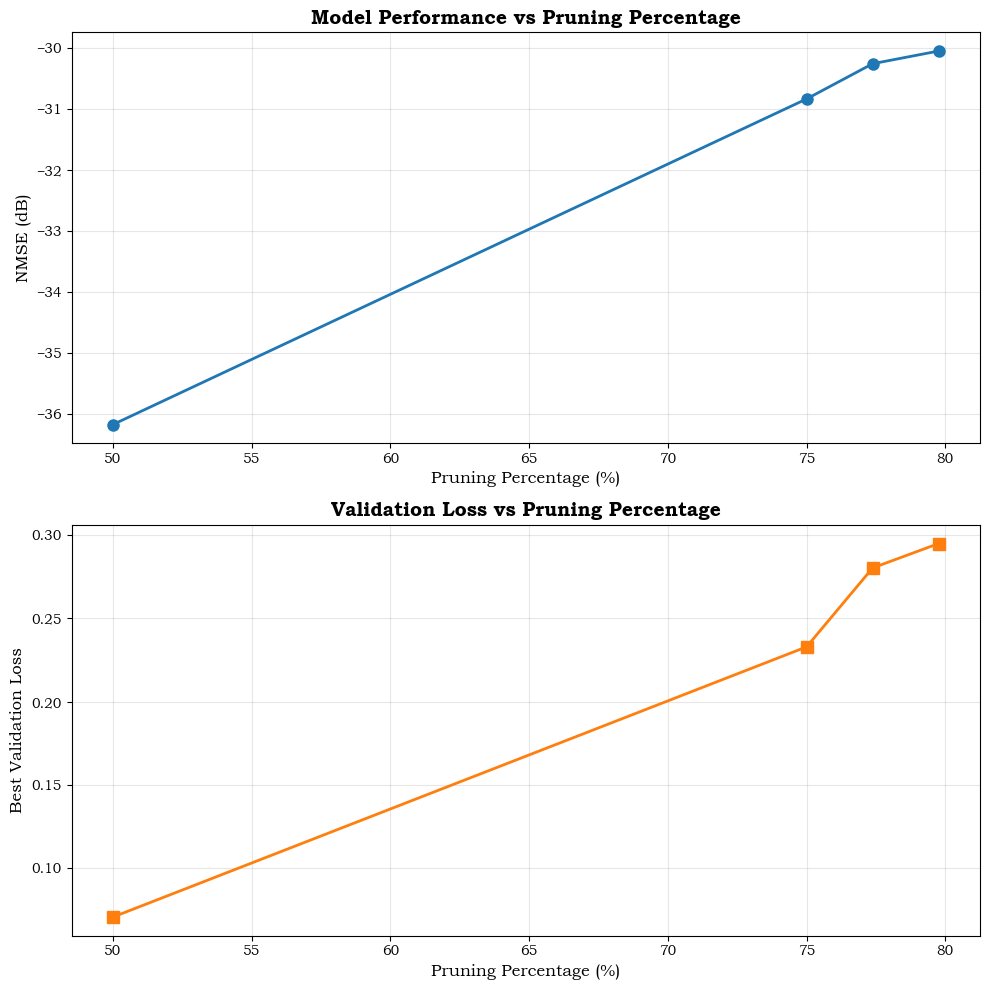


RUNNING NON-LINEAR PRUNING EXPERIMENT

Pruning Iteration 1/4
Pruning 50.0% of remaining weights...
Current pruning: 50.00% of weights are zero
Retraining for 500 epochs...
Epoch  10/500  Loss=3.3135e-01  Valid Loss=3.3116e-01
Epoch  10/500  Loss=3.3135e-01  Valid Loss=3.3116e-01
Epoch  20/500  Loss=1.9291e-01  Valid Loss=2.0098e-01
Epoch  20/500  Loss=1.9291e-01  Valid Loss=2.0098e-01
Epoch  30/500  Loss=1.3546e-01  Valid Loss=1.4503e-01
Epoch  30/500  Loss=1.3546e-01  Valid Loss=1.4503e-01
Epoch  40/500  Loss=1.0839e-01  Valid Loss=1.1776e-01
Epoch  40/500  Loss=1.0839e-01  Valid Loss=1.1776e-01
Epoch  50/500  Loss=9.2567e-02  Valid Loss=1.0196e-01
Epoch  50/500  Loss=9.2567e-02  Valid Loss=1.0196e-01
Epoch  60/500  Loss=8.2562e-02  Valid Loss=9.2040e-02
Epoch  60/500  Loss=8.2562e-02  Valid Loss=9.2040e-02
Epoch  70/500  Loss=7.6208e-02  Valid Loss=8.5312e-02
Epoch  70/500  Loss=7.6208e-02  Valid Loss=8.5312e-02
Epoch  80/500  Loss=7.1879e-02  Valid Loss=8.3818e-02
Epoch  80/500  Lo

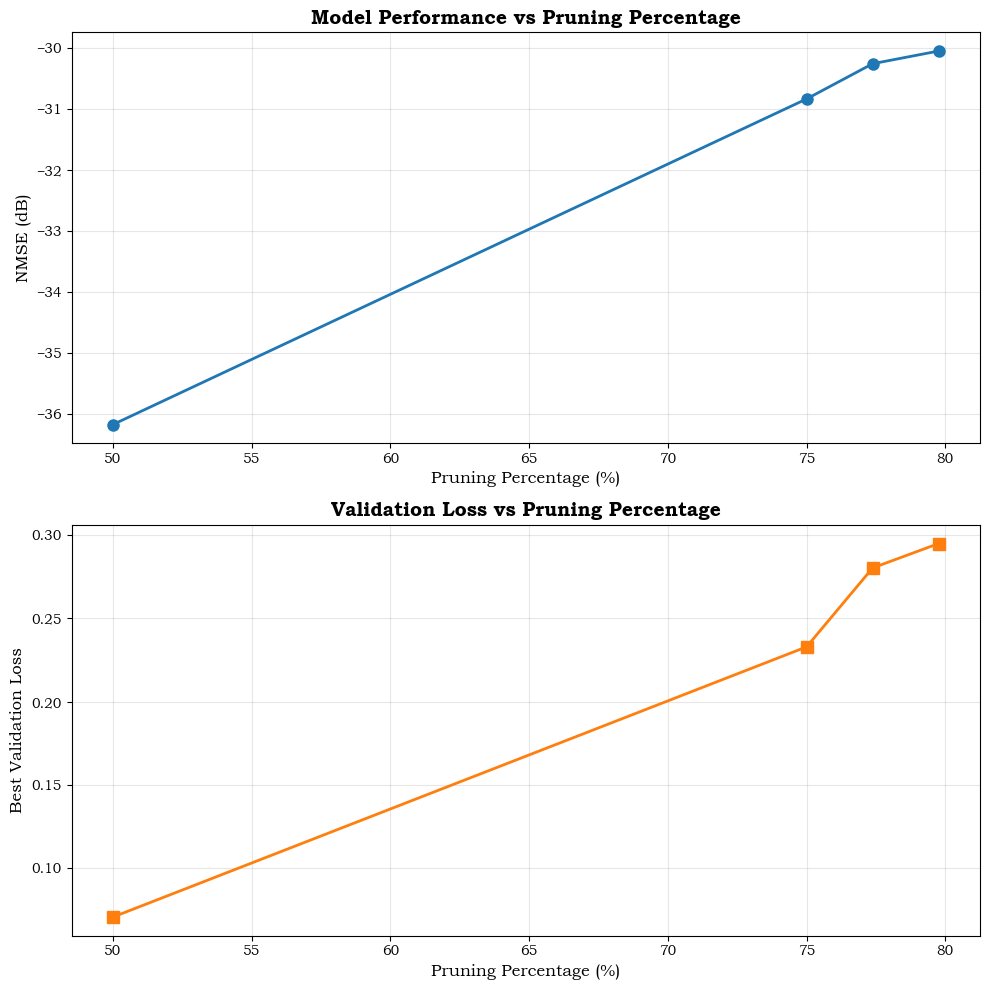


COMPARING PRUNING STRATEGIES



RUNNING NON-LINEAR PRUNING EXPERIMENT

Pruning Iteration 1/4
Pruning 50.0% of remaining weights...
Current pruning: 50.00% of weights are zero
Retraining for 500 epochs...
Epoch  10/500  Loss=3.3135e-01  Valid Loss=3.3116e-01
Epoch  10/500  Loss=3.3135e-01  Valid Loss=3.3116e-01
Epoch  20/500  Loss=1.9291e-01  Valid Loss=2.0098e-01
Epoch  20/500  Loss=1.9291e-01  Valid Loss=2.0098e-01
Epoch  30/500  Loss=1.3546e-01  Valid Loss=1.4503e-01
Epoch  30/500  Loss=1.3546e-01  Valid Loss=1.4503e-01
Epoch  40/500  Loss=1.0839e-01  Valid Loss=1.1776e-01
Epoch  40/500  Loss=1.0839e-01  Valid Loss=1.1776e-01
Epoch  50/500  Loss=9.2567e-02  Valid Loss=1.0196e-01
Epoch  50/500  Loss=9.2567e-02  Valid Loss=1.0196e-01
Epoch  60/500  Loss=8.2562e-02  Valid Loss=9.2040e-02
Epoch  60/500  Loss=8.2562e-02  Valid Loss=9.2040e-02
Epoch  70/500  Loss=7.6208e-02  Valid Loss=8.5312e-02
Epoch  70/500  Loss=7.6208e-02  Valid Loss=8.5312e-02
Epoch  80/500  Loss=7.1879e-02  Valid Loss=8.3818e-02
Epoch  80/500  Lo

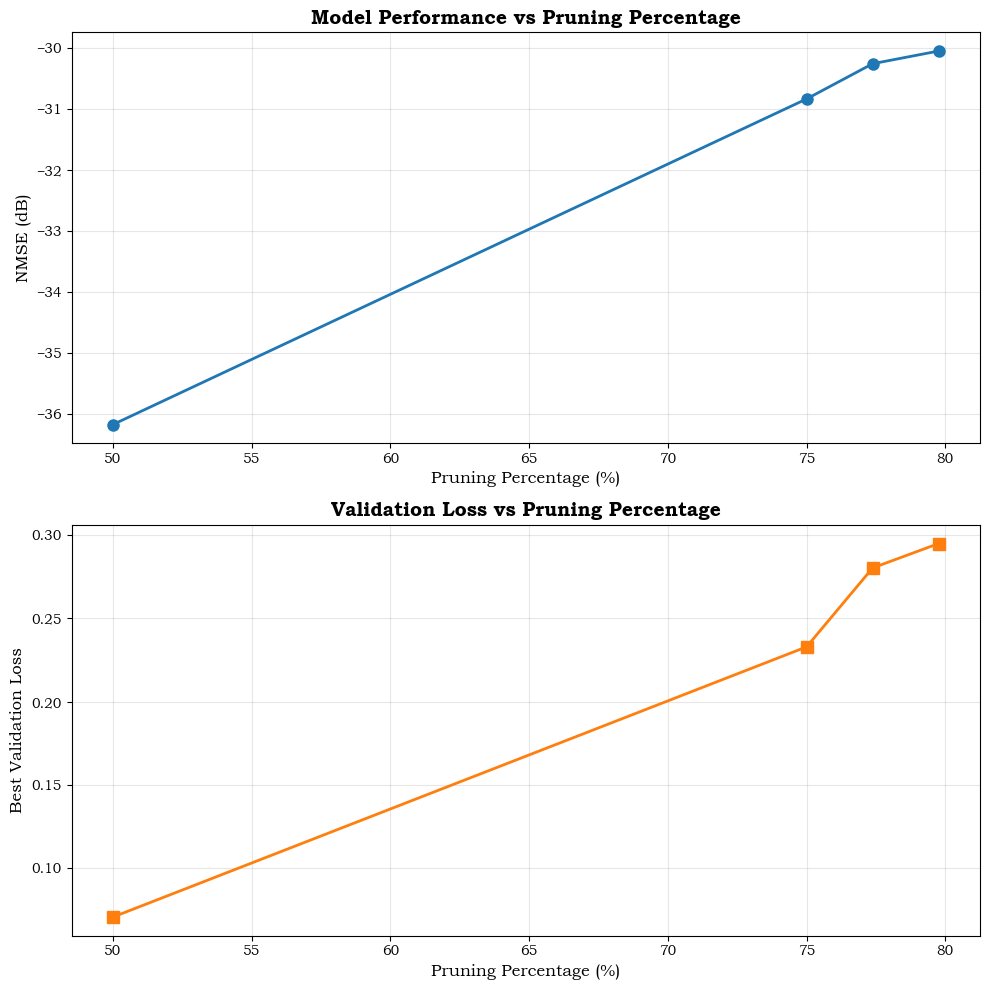


COMPARING PRUNING STRATEGIES


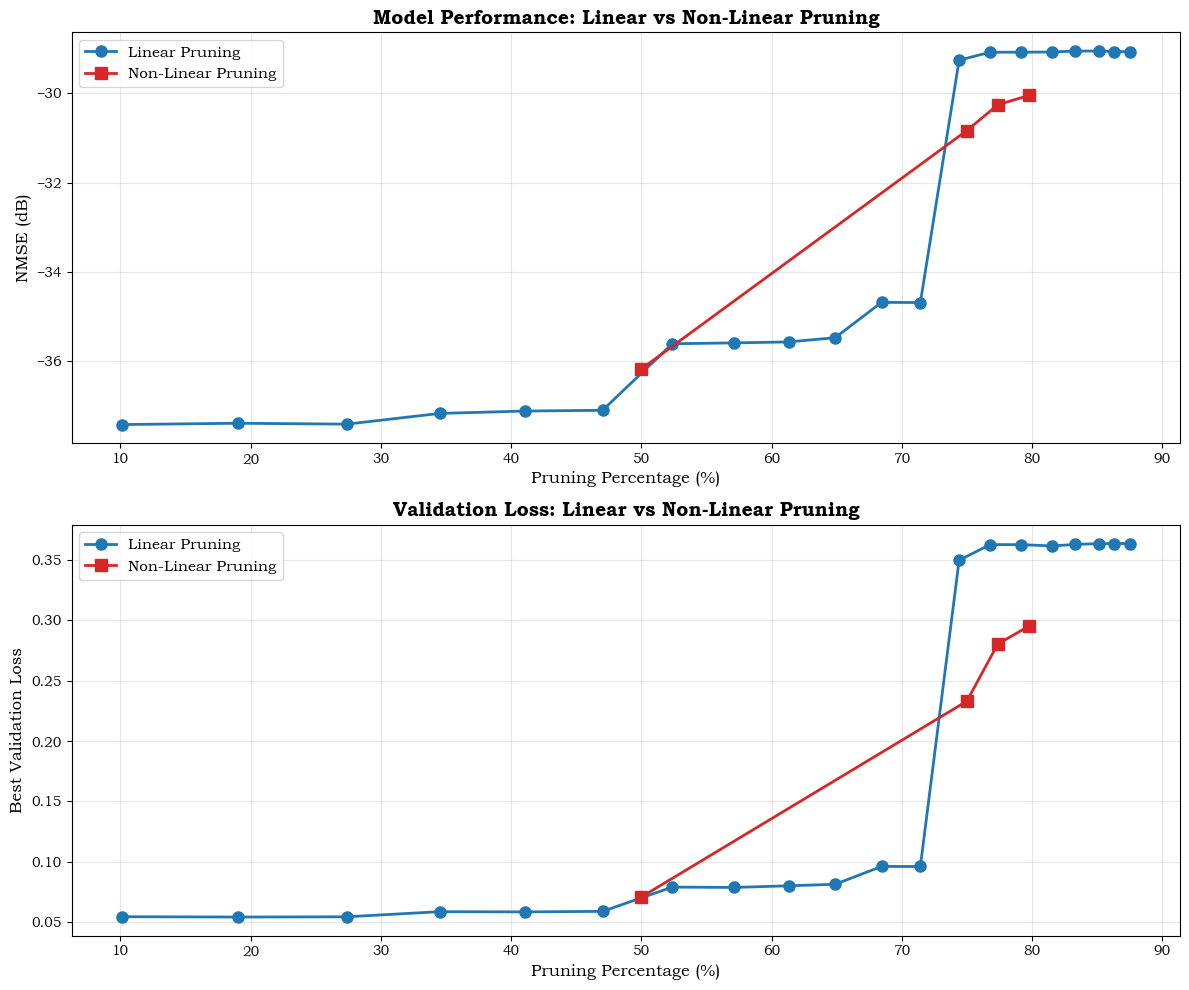

In [ ]:
# Run non-linear pruning experiment
print("\n" + "="*70)
print("RUNNING NON-LINEAR PRUNING EXPERIMENT")
print("="*70)
nonlinear_prune_schedule = [0.5, 0.5, 0.1, 0.1]  # Custom pruning schedule
nonlinear_experiment = Non_Linear_Prune_Experiment(nn_model, prune_schedule=nonlinear_prune_schedule, 
                                                    retrain_epochs=500,
                                                    model_xfc=model_xfc, 
                                                    model_training_expected_output=model_training_expected_output,
                                                    valid_xfc=valid_xfc, 
                                                    model_valid_expected_output=model_valid_expected_output)
nonlinear_prune_pct, nonlinear_nmse, nonlinear_valid = nonlinear_experiment.run()

# Compare both strategies
print("\n" + "="*70)
print("COMPARING PRUNING STRATEGIES")
print("="*70)
Non_Linear_Prune_Experiment.compare_pruning_strategies(
    (linear_prune_pct, linear_nmse, linear_valid),
    (nonlinear_prune_pct, nonlinear_nmse, nonlinear_valid)
)

In [ ]:
# Experiment on just pruning F1

class Prune_fc1_only_Experiment:
    def __init__(self, nn_model, num_prune_iterations, prune_amount, retrain_epochs, model_xfc, model_training_expected_output, valid_xfc, model_valid_expected_output):
        self.original_nn_model = nn_model  # Keep original model untouched
        self.nn_model = None  # Will be set to working copy
        self.num_prune_iterations = num_prune_iterations
        self.prune_amount = prune_amount
        self.retrain_epochs = retrain_epochs
        self.model_xfc = model_xfc
        self.model_training_expected_output = model_training_expected_output
        self.valid_xfc = valid_xfc
        self.model_valid_expected_output = model_valid_expected_output
    
    def run(self):
        nmse_results = []
        prune_percentages = []
        valid_losses_final = []
        all_valid_losses = []
        all_best_epochs = []
        
        # Create a working copy from the original model
        working_pntdnn = copy.deepcopy(self.original_nn_model.pntdnn)
        self.nn_model = NN(working_pntdnn)

        for i in range(self.num_prune_iterations):
            print(f"\n{'='*60}")
            print(f"Pruning Iteration {i+1}/{self.num_prune_iterations}")
            print(f"{'='*60}")
            
            # Apply pruning to the current model (iterative pruning of remaining weights)
            print(f"Pruning {self.prune_amount*100:.1f}% of remaining fc1 weights...")
            self.nn_model.prune_model(["fc1"], self.prune_amount)
            
            # Calculate current pruning percentage
            current_prune_pct = self.nn_model.get_pruning_percentage()
            prune_percentages.append(current_prune_pct)
            print(f"Current pruning: {current_prune_pct:.2f}% of weights are zero")
            
            # Retrain the model
            print(f"Retraining for {self.retrain_epochs} epochs...")
            train_loader = self.nn_model.build_dataloaders(self.model_xfc, self.model_training_expected_output)
            valid_loader = self.nn_model.build_dataloaders(self.valid_xfc, self.model_valid_expected_output)
            train_losses, valid_losses, best_epoch = self.nn_model.get_best_model(
                train_loader, valid_loader, num_epochs=self.retrain_epochs
            )
            
            # Store validation losses and best epoch
            all_valid_losses.append(valid_losses)
            all_best_epochs.append(best_epoch)
            valid_losses_final.append(min(valid_losses))
            
            # Calculate NMSE
            nmse = self.nn_model.calculate_nmse(self.model_xfc, self.model_training_expected_output)
            nmse_results.append(nmse)
            print(f"NMSE: {nmse:.4f} dB")

        self.plot_results(prune_percentages, nmse_results, valid_losses_final)
        # self.plot_training_curves(all_valid_losses, all_best_epochs, prune_percentages)
        
        return prune_percentages, nmse_results, valid_losses_final

    def plot_results(self, prune_percentages, nmse_results, valid_losses):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
        
        # Plot NMSE
        ax1.plot(prune_percentages, nmse_results, marker='o', linewidth=2, markersize=8, color='tab:blue')
        ax1.set_xlabel('Pruning Percentage (%)', fontsize=12)
        ax1.set_ylabel('NMSE (dB)', fontsize=12)
        ax1.set_title('Model Performance vs Pruning Percentage', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        
        # Plot Validation Loss
        ax2.plot(prune_percentages, valid_losses, marker='s', linewidth=2, markersize=8, color='tab:orange')
        ax2.set_xlabel('Pruning Percentage (%)', fontsize=12)
        ax2.set_ylabel('Best Validation Loss', fontsize=12)
        ax2.set_title('Validation Loss vs Pruning Percentage', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_training_curves(self, all_valid_losses, all_best_epochs, prune_percentages):
        """Plot validation loss curves for each pruning iteration with best epoch markers"""
        n_iterations = len(all_valid_losses)
        colors = plt.cm.viridis(np.linspace(0, 1, n_iterations))
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        for i, (valid_losses, best_epoch, prune_pct, color) in enumerate(zip(all_valid_losses, all_best_epochs, prune_percentages, colors)):
            epochs = range(1, len(valid_losses) + 1)
            label = f'Iter {i+1}: {prune_pct:.1f}% pruned'
            
            # Plot validation loss curve
            ax.plot(epochs, valid_losses, linewidth=2, color=color, label=label, alpha=0.7)
            
            # Add vertical line at best epoch
            ax.axvline(x=best_epoch, color=color, linestyle='--', linewidth=1.5, alpha=0.8)
            
            # Add marker at best epoch
            best_loss = valid_losses[best_epoch - 1]
            ax.plot(best_epoch, best_loss, marker='*', markersize=12, color=color, 
                   markeredgecolor='black', markeredgewidth=1)
        
        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel('Validation Loss', fontsize=12)
        ax.set_title('Validation Loss Curves for Each Pruning Iteration', fontsize=14, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    

RUNNING FC1 ONLY PRUNING EXPERIMENT

Pruning Iteration 1/20
Pruning 10.0% of remaining fc1 weights...
Current pruning: 8.33% of weights are zero
Retraining for 200 epochs...
Epoch  10/200  Loss=4.6811e-02  Valid Loss=5.5315e-02
Epoch  10/200  Loss=4.6811e-02  Valid Loss=5.5315e-02
Epoch  20/200  Loss=4.6576e-02  Valid Loss=5.5206e-02
Epoch  20/200  Loss=4.6576e-02  Valid Loss=5.5206e-02
Epoch  30/200  Loss=4.6488e-02  Valid Loss=6.1521e-02
Epoch  30/200  Loss=4.6488e-02  Valid Loss=6.1521e-02
Epoch  40/200  Loss=4.7684e-02  Valid Loss=5.4867e-02
Epoch  40/200  Loss=4.7684e-02  Valid Loss=5.4867e-02
Epoch  50/200  Loss=4.7503e-02  Valid Loss=5.6304e-02
Epoch  50/200  Loss=4.7503e-02  Valid Loss=5.6304e-02
Epoch  60/200  Loss=4.6415e-02  Valid Loss=5.5111e-02
Epoch  60/200  Loss=4.6415e-02  Valid Loss=5.5111e-02
Epoch  70/200  Loss=4.7105e-02  Valid Loss=5.5255e-02
Epoch  70/200  Loss=4.7105e-02  Valid Loss=5.5255e-02
Epoch  80/200  Loss=4.8097e-02  Valid Loss=5.7547e-02
Epoch  80/200  L

RUNNING FC1 ONLY PRUNING EXPERIMENT

Pruning Iteration 1/20
Pruning 10.0% of remaining fc1 weights...
Current pruning: 8.33% of weights are zero
Retraining for 200 epochs...
Epoch  10/200  Loss=4.6811e-02  Valid Loss=5.5315e-02
Epoch  10/200  Loss=4.6811e-02  Valid Loss=5.5315e-02
Epoch  20/200  Loss=4.6576e-02  Valid Loss=5.5206e-02
Epoch  20/200  Loss=4.6576e-02  Valid Loss=5.5206e-02
Epoch  30/200  Loss=4.6488e-02  Valid Loss=6.1521e-02
Epoch  30/200  Loss=4.6488e-02  Valid Loss=6.1521e-02
Epoch  40/200  Loss=4.7684e-02  Valid Loss=5.4867e-02
Epoch  40/200  Loss=4.7684e-02  Valid Loss=5.4867e-02
Epoch  50/200  Loss=4.7503e-02  Valid Loss=5.6304e-02
Epoch  50/200  Loss=4.7503e-02  Valid Loss=5.6304e-02
Epoch  60/200  Loss=4.6415e-02  Valid Loss=5.5111e-02
Epoch  60/200  Loss=4.6415e-02  Valid Loss=5.5111e-02
Epoch  70/200  Loss=4.7105e-02  Valid Loss=5.5255e-02
Epoch  70/200  Loss=4.7105e-02  Valid Loss=5.5255e-02
Epoch  80/200  Loss=4.8097e-02  Valid Loss=5.7547e-02
Epoch  80/200  L

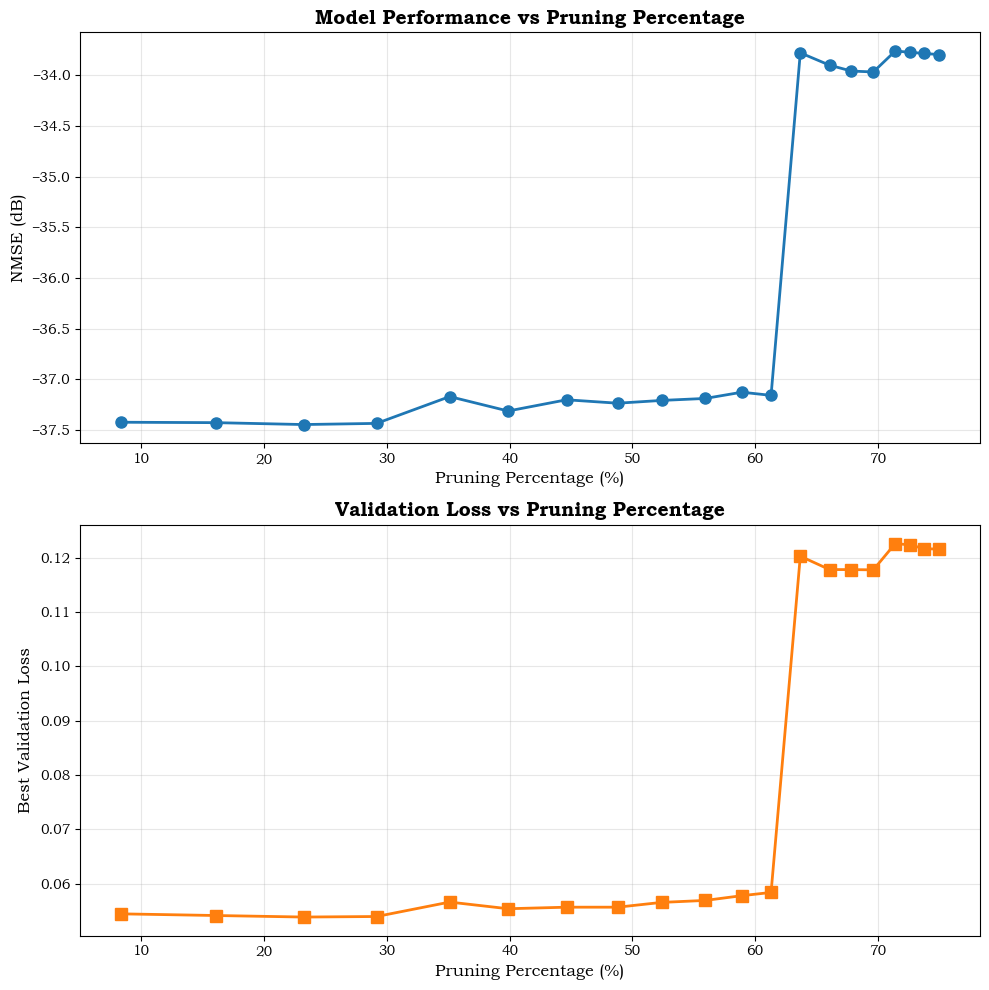

In [ ]:
# Run fc1 only pruning experiment
print("="*70)
print("RUNNING FC1 ONLY PRUNING EXPERIMENT")
print("="*70)
fc1_only_experiment = Prune_fc1_only_Experiment(nn_model, num_prune_iterations=20, prune_amount=0.1, retrain_epochs=200,
                               model_xfc=model_xfc, model_training_expected_output=model_training_expected_output,
                               valid_xfc=valid_xfc, model_valid_expected_output=model_valid_expected_output)
fc1_prune_pct, fc1_nmse, fc1_valid = fc1_only_experiment.run()

In [ ]:
# Train 3 layer NN
# Instantiate and train the model
input_size = model_xfc.shape[1]
hidden_size_1 = 12
hidden_size_2e = 2
PNTDNN_3_layers_model = PNTDNN_3_layers(input_size, hidden_size_1, hidden_sze_2, utput


_
size)


Epoch  10/2000  Loss=2.7802e+01  Valid Loss=2.3074e+01
Epoch  20/2000  Loss=1.0858e+00  Valid Loss=1.1208e+00
Epoch  20/2000  Loss=1.0858e+00  Valid Loss=1.1208e+00
Epoch  30/2000  Loss=4.9885e-01  Valid Loss=5.6640e-01
Epoch  30/2000  Loss=4.9885e-01  Valid Loss=5.6640e-01
Epoch  40/2000  Loss=3.3906e-01  Valid Loss=3.8828e-01
Epoch  40/2000  Loss=3.3906e-01  Valid Loss=3.8828e-01
Epoch  50/2000  Loss=2.4642e-01  Valid Loss=2.8604e-01
Epoch  50/2000  Loss=2.4642e-01  Valid Loss=2.8604e-01
Epoch  60/2000  Loss=1.9738e-01  Valid Loss=2.3126e-01
Epoch  60/2000  Loss=1.9738e-01  Valid Loss=2.3126e-01
Epoch  70/2000  Loss=1.6924e-01  Valid Loss=1.9866e-01
Epoch  70/2000  Loss=1.6924e-01  Valid Loss=1.9866e-01
Epoch  80/2000  Loss=1.5352e-01  Valid Loss=1.8538e-01
Epoch  80/2000  Loss=1.5352e-01  Valid Loss=1.8538e-01
Epoch  90/2000  Loss=1.4581e-01  Valid Loss=1.7248e-01
Epoch  90/2000  Loss=1.4581e-01  Valid Loss=1.7248e-01
Epoch 100/2000  Loss=1.3390e-01  Valid Loss=1.6124e-01
Epoch 100/

In [ ]:
# Train a 1 layer model with a bigger hidden layer
input_size = model_xfc.shape[1]
hidden_size = 20
output_size = 2
pntdnn = PNTDNN(input_size, hidden_size)
nn_model = NN(pntdnn)
train_loader = nn_model.build_dataloaders(model_xfc, model_training_expected_output)
valid_loader = nn_model.build_dataloaders(valid_xfc, model_valid_expected_output)
train_losses, valid_losses, best_epoch = nn_model.get_best_model(train_loader, valid_loader, num_epochs=2000)
print(nn_model.calculate_nmse(model_xfc, model_training_expected_output))


Epoch  10/2000  Loss=4.7182e+00  Valid Loss=4.2641e+00
Epoch  20/2000  Loss=1.0059e+00  Valid Loss=1.0982e+00
Epoch  20/2000  Loss=1.0059e+00  Valid Loss=1.0982e+00
Epoch  30/2000  Loss=6.1862e-01  Valid Loss=7.2354e-01
Epoch  30/2000  Loss=6.1862e-01  Valid Loss=7.2354e-01
Epoch  40/2000  Loss=4.5191e-01  Valid Loss=5.3775e-01
Epoch  40/2000  Loss=4.5191e-01  Valid Loss=5.3775e-01
Epoch  50/2000  Loss=3.3174e-01  Valid Loss=4.0143e-01
Epoch  50/2000  Loss=3.3174e-01  Valid Loss=4.0143e-01
Epoch  60/2000  Loss=2.4211e-01  Valid Loss=2.9522e-01
Epoch  60/2000  Loss=2.4211e-01  Valid Loss=2.9522e-01
Epoch  70/2000  Loss=1.7935e-01  Valid Loss=2.2142e-01
Epoch  70/2000  Loss=1.7935e-01  Valid Loss=2.2142e-01
Epoch  80/2000  Loss=1.3697e-01  Valid Loss=1.7315e-01
Epoch  80/2000  Loss=1.3697e-01  Valid Loss=1.7315e-01
Epoch  90/2000  Loss=1.1381e-01  Valid Loss=1.4411e-01
Epoch  90/2000  Loss=1.1381e-01  Valid Loss=1.4411e-01
Epoch 100/2000  Loss=1.0053e-01  Valid Loss=1.2768e-01
Epoch 100/

In [ ]:
# Train a model with 1 smaller hidden layer
input_size = model_xfc.shape[1]
hidden_size = 7
output_size = 2
pntdnn = PNTDNN(input_size, hidden_size, output_size)
nn_model = NN(pntdnn)
train_loader = nn_model.build_dataloaders(model_xfc, model_training_expected_output)
valid_loader = nn_model.build_dataloaders(valid_xfc, model_valid_expected_output)
train_losses, valid_losses, best_epoch = nn_model.get_best_model(train_loader, valid_loader, num_epochs=2000)
print(nn_model.calculate_nmse(model_xfc, model_training_expected_output))



Epoch  10/2000  Loss=2.2861e+01  Valid Loss=1.8479e+01
Epoch  20/2000  Loss=1.9594e+00  Valid Loss=1.9288e+00
Epoch  20/2000  Loss=1.9594e+00  Valid Loss=1.9288e+00
Epoch  30/2000  Loss=6.6449e-01  Valid Loss=7.6587e-01
Epoch  30/2000  Loss=6.6449e-01  Valid Loss=7.6587e-01
Epoch  40/2000  Loss=4.1186e-01  Valid Loss=4.8809e-01
Epoch  40/2000  Loss=4.1186e-01  Valid Loss=4.8809e-01
Epoch  50/2000  Loss=3.1416e-01  Valid Loss=3.6152e-01
Epoch  50/2000  Loss=3.1416e-01  Valid Loss=3.6152e-01
Epoch  60/2000  Loss=2.6344e-01  Valid Loss=2.9832e-01
Epoch  60/2000  Loss=2.6344e-01  Valid Loss=2.9832e-01
Epoch  70/2000  Loss=2.2910e-01  Valid Loss=2.5608e-01
Epoch  70/2000  Loss=2.2910e-01  Valid Loss=2.5608e-01
Epoch  80/2000  Loss=2.0480e-01  Valid Loss=2.2953e-01
Epoch  80/2000  Loss=2.0480e-01  Valid Loss=2.2953e-01
Epoch  90/2000  Loss=1.8529e-01  Valid Loss=2.1087e-01
Epoch  90/2000  Loss=1.8529e-01  Valid Loss=2.1087e-01
Epoch 100/2000  Loss=1.7098e-01  Valid Loss=1.9367e-01
Epoch 100/